# Análise dos dados presentes nos arquivos da camada Bronze / Raw

### Análise de Dados
A análise será conduzida em diferentes etapas. Primeiro, apresentaremos um panorama geral de cada arquivo, incluindo o número de linhas, colunas e o tipo de conteúdo presente em cada campo.
Em seguida, aprofundaremos a avaliação identificando colunas com valores ausentes, inconsistências, caracteres inválidos e demais problemas de qualidade que possam impactar as próximas fases do pipeline.

### Configurando Ambiente
Para acessar os dados, é necessário abrir cada arquivo, ler seu conteúdo e processar cada linha. Para facilitar essa tarefa, utilizaremos a biblioteca pandas, que oferece funcionalidades eficientes para manipulação e análise de dados. Para utilizar essa ferramenta, devemos primeiro importá-la em nosso código.

In [50]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import re
import glob
import os

### Leitura dos dados
Primeiramente definimos o caminho onde se encontra a nossa base da dados Raw, salva em arquivos.

In [51]:
pasta = "dados_brutos" 
arquivos_csv = glob.glob(os.path.join(pasta, "*.csv"))
lista_arquivos = []

for arquivo in arquivos_csv:
    conteudo = pandas.read_csv(arquivo, encoding='latin1', sep=';', skiprows=2)
    lista_arquivos.append(conteudo)

conteudo_arquivo = pandas.concat(lista_arquivos, ignore_index=True)

### Informações gerais do arquivo

Precisamos agora entender qual o tamanho da base e tambem a qualidade dos dados, para isso precisamos verificar o tipo de dados que estamos tratando e a quantidade de informmações vazias ou nulas.

In [52]:

total_linhas = len(conteudo_arquivo)

print(f'Total de registros: {total_linhas}')

analise_colunas = []

for coluna in conteudo_arquivo.columns:
    tipo = conteudo_arquivo[coluna].dtype
    qtd_vazios = conteudo_arquivo[coluna].isna().sum()
    pct_vazios = (qtd_vazios / total_linhas) * 100

    analise_colunas.append({
        "Coluna": coluna,
        "Tipo": tipo,
        "Linhas Vazias": qtd_vazios,
        "% Vazias": f"{pct_vazios:.2f}%"
    })


tabela_analise = pandas.DataFrame(analise_colunas)
tabela_analise

Total de registros: 126


,Coluna,Tipo,Linhas Vazias,% Vazias
0,N° do imóvel,int64,0,0.00%
1,UF,object,0,0.00%
2,Cidade,object,0,0.00%
3,Bairro,object,0,0.00%
4,Endereço,object,0,0.00%
5,Preço,object,0,0.00%
6,Valor de avaliação,object,0,0.00%
7,Desconto,float64,0,0.00%
8,Descrição,object,0,0.00%
9,Modalidade de venda,object,0,0.00%


Agora podemos dar uma uma olhada nos dados presentes no arquivo com o seguinte comando:

In [53]:
display(conteudo_arquivo.head(3))

,N° do imóvel,UF,Cidade,Bairro,Endereço,Preço,Valor de avaliação,Desconto,Descrição,Modalidade de venda,Link de acesso
0,8787700428805,DF,BRASILIA,RIACHO FUNDO II,"QUADRA QN 23, N. SN, Apto 302, CJ 02, BL 08, L...","20.500,00","205.000,00",90.00,"Apartamento, 0.00 de área total, 50.10 de área...",Venda Online,https://venda-imoveis.caixa.gov.br/sistema/det...
1,8787711984607,DF,BRASILIA,ST HAB ITAPOA,"AVENIDA TERCEIRA AVENIDA MERCADO, N. SN, Apto ...","73.948,67","127.657,69",42.08,"Apartamento, 0.00 de área total, 46.40 de área...",Licitação Aberta,https://venda-imoveis.caixa.gov.br/sistema/det...
2,8787709151121,DF,BRASILIA,SAMAMBAIA SUL (SAMAMBAIA),"QUADRA 101, N. SN, Apto 607, LT 04 CJ 04 BL C...","105.481,84","178.000,00",40.75,"Apartamento, 43.68 de área total, 32.30 de áre...",Licitação Aberta,https://venda-imoveis.caixa.gov.br/sistema/det...


Ao analisar as primeiras colunas, já podemos perceber que algumas precisam ser ajustadas:

- Preço

- Valor de avaliação

- Desconto

Atualmente, essas colunas estão em um formato numérico incorreto, usando . como separador de milhares e , como separador decimal. Para que possamos prosseguir com a análise, é necessário padronizar os números para o formato correto (00,00). Para isso, utilizaremos o seguinte código:

In [54]:
colunas_numericas = [5, 6, 7]

for coluna in colunas_numericas:
    conteudo_arquivo.iloc[:, coluna] = (
        conteudo_arquivo.iloc[:, coluna]
        .astype(str)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False)  
        .astype(float)
    )

Agora podemos visualizar novamente os dados para confirmar se os ajustes realizados foram aplicados corretamente.

In [55]:
display(conteudo_arquivo.head(3))

,N° do imóvel,UF,Cidade,Bairro,Endereço,Preço,Valor de avaliação,Desconto,Descrição,Modalidade de venda,Link de acesso
0,8787700428805,DF,BRASILIA,RIACHO FUNDO II,"QUADRA QN 23, N. SN, Apto 302, CJ 02, BL 08, L...",20500.0,205000.0,900.0,"Apartamento, 0.00 de área total, 50.10 de área...",Venda Online,https://venda-imoveis.caixa.gov.br/sistema/det...
1,8787711984607,DF,BRASILIA,ST HAB ITAPOA,"AVENIDA TERCEIRA AVENIDA MERCADO, N. SN, Apto ...",73948.67,127657.69,4208.0,"Apartamento, 0.00 de área total, 46.40 de área...",Licitação Aberta,https://venda-imoveis.caixa.gov.br/sistema/det...
2,8787709151121,DF,BRASILIA,SAMAMBAIA SUL (SAMAMBAIA),"QUADRA 101, N. SN, Apto 607, LT 04 CJ 04 BL C...",105481.84,178000.0,4075.0,"Apartamento, 43.68 de área total, 32.30 de áre...",Licitação Aberta,https://venda-imoveis.caixa.gov.br/sistema/det...


## Lidando com informações de valores ausentes

Um ponto importante na construção da nossa base é a consistência dos valores relacionados aos imóveis. Por isso, precisamos verificar se cada registro possui o preço de venda e o valor de avaliação devidamente informados. Caso qualquer um desses dados esteja ausente, será necessário aplicar um tratamento adequado antes de avançarmos para as próximas etapas.

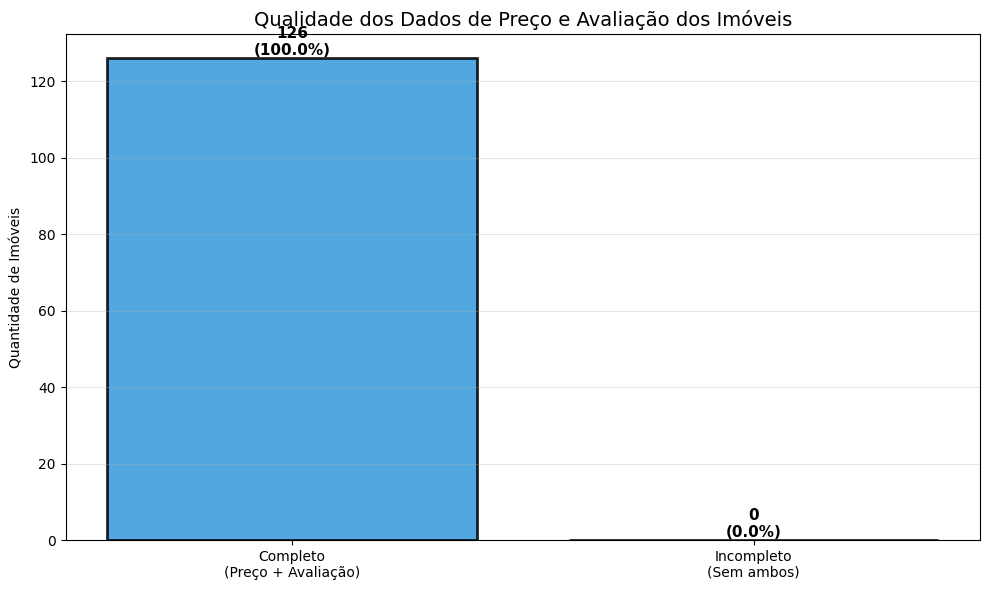

In [56]:
coluna_preco = 5
coluna_valor_avaliacao = 6
sem_preco = conteudo_arquivo.iloc[:, coluna_preco].isnull() | (conteudo_arquivo.iloc[:, coluna_preco] == '')
sem_avaliacao = conteudo_arquivo.iloc[:, coluna_valor_avaliacao].isnull() | (conteudo_arquivo.iloc[:, coluna_valor_avaliacao] == '')

categorias = [
    'Completo\n(Preço + Avaliação)',
    'Incompleto\n(Sem ambos)'
]

valores = [
    ((~sem_preco) & (~sem_avaliacao)).sum(),
    (sem_preco & sem_avaliacao).sum()
]

cores = ['#3498db', '#e74c3c']  

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categorias, valores, color=cores, alpha=0.85, edgecolor='black', linewidth=2)

ax.set_ylabel('Quantidade de Imóveis')
ax.set_title('Qualidade dos Dados de Preço e Avaliação dos Imóveis', fontsize=14)
ax.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{valores[i]:,.0f}\n({valores[i] / len(conteudo_arquivo) * 100:.1f}%)',
        ha='center', va='bottom',
        fontsize=11,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

Outra informações sobre o imóvel tambem são importantes, como:
- Número de banheiros;
- Área privativa (m²);
- Quantidade de quartos;
- Numero de vagas na garagem;

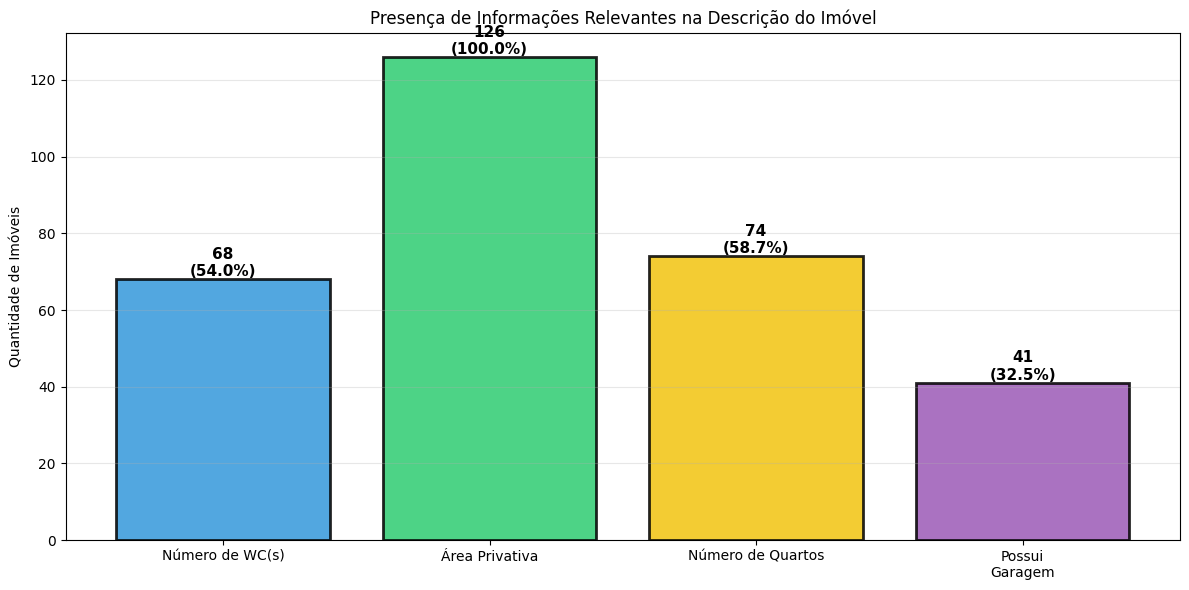

In [57]:
coluna_descricao = 8
conteudo_arquivo.iloc[:,coluna_descricao] = conteudo_arquivo.iloc[:,coluna_descricao].fillna('').astype(str)

padrao_wc = r'\b(?:WC|banheiro|banheiros|sanitário|sanitários|toalete)\b'
padrao_area = r'(?:area privativa|área privativa|m²|m2|metros quadrados|metro quadrado)'
padrao_quartos = r'(?:quarto|quartos|dormitório|dormitórios|qto|qtos|dorms?)'
padrao_garagem = r'(?:garagem|vaga|vagas)'

tem_wc = conteudo_arquivo.iloc[:,coluna_descricao].str.contains(padrao_wc, flags=re.IGNORECASE, regex=True)
tem_area = conteudo_arquivo.iloc[:,coluna_descricao].str.contains(padrao_area, flags=re.IGNORECASE, regex=True)
tem_quartos = conteudo_arquivo.iloc[:,coluna_descricao].str.contains(padrao_quartos, flags=re.IGNORECASE, regex=True)
tem_garagem = conteudo_arquivo.iloc[:,coluna_descricao].str.contains(padrao_garagem, flags=re.IGNORECASE, regex=True)

categorias = [
    'Número de WC(s)',
    'Área Privativa',
    'Número de Quartos',
    'Possui\nGaragem'
]

valores = [
    tem_wc.sum(),
    tem_area.sum(),
    tem_quartos.sum(),
    tem_garagem.sum()
]

total = len(conteudo_arquivo)

cores = ['#3498db', '#2ecc71', '#f1c40f', '#9b59b6']

fig, ax = plt.subplots(figsize=(12, 6))

barras = ax.bar(categorias, valores, color=cores, edgecolor='black', linewidth=2, alpha=0.85)

ax.set_ylabel('Quantidade de Imóveis')
ax.set_title('Presença de Informações Relevantes na Descrição do Imóvel')
ax.grid(axis='y', alpha=0.3)

# Rótulos com valores e porcentagens
for i, bar in enumerate(barras):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., height,
        f'{valores[i]:,.0f}\n({valores[i]/total*100:.1f}%)',
        ha='center', va='bottom', fontsize=11, fontweight='bold'
    )

plt.tight_layout()
plt.show()
